# Sentiment Analysis on IMDb Dataset with BERT

This project fine-tunes a BERT model (`bert-base-uncased`) for binary sentiment classification (positive=1, negative=0) on the IMDb dataset. The goal is to predict movie review sentiments accurately, leveraging BERT's pre-trained contextual understanding.

---

## 1. Install Dependencies
Install the `datasets` library to load the IMDb dataset.

In [2]:
!pip install datasets

---

## 2. Load the IMDb Dataset
Load the IMDb dataset from Hugging Face, which contains 25,000 labeled training reviews, 25,000 labeled test reviews, and 50,000 unlabeled reviews. We’ll use the labeled splits for supervised learning.

In [3]:
# Load the IMDb dataset
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

---

## 3. Explore the Dataset
Examine the training split to understand its features (`text` and `label`) and size.

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [6]:
dataset['train'].to_pandas()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [7]:
#!pip install transformers

---

## 4. Preprocess the Data
Tokenize the text using `bert-base-uncased` to convert reviews into a format BERT can process. We set `max_length=256` to balance detail and computational efficiency.

In [9]:
from transformers import BertTokenizer

In [10]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

"bert-base-uncased": A version of BERT that’s smaller (base) and case-insensitive (uncased). The tokenizer converts text into tokens that BERT understands, like splitting words into subwords (e.g., "playing" → ["play", "##ing"]).

The tokenizer uses a vocabulary of about 30,000 tokens that BERT was trained on, including words, subwords, and special tokens.

In [11]:
# # Tokenize the dataset
# def preprocess_function(examples):
#     return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

In [12]:
# Define a function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

* tokenizer(...): Tokenizes the text with these settings:
* truncation=True: Cuts off text longer than max_length (256 tokens here).
* padding="max_length": Pads shorter text with special [PAD] tokens to reach 256 tokens.
* max_length=256: Sets the maximum sequence length to 256 tokens.

Returns a dictionary with input_ids (token IDs), attention_mask (which tokens to pay attention to), and possibly token_type_ids (for distinguishing sentence pairs, though not needed for sentiment analysis).

In [13]:
# Apply the tokenizer to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [14]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [15]:
# Set format for PyTorch
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [16]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [17]:
# Prepare the dataset for training (remove unnecessary columns and set format)
tokenized_dataset = tokenized_dataset.remove_columns(['text'])  # Remove raw text column
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')  # Rename 'label' to 'labels' for Trainer
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])  # Set to PyTorch tensors

In [18]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

### Splitting the Dataset

In [19]:
# # Split into train and validation sets (use 10% of train for validation)
# train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(22500))  # 90% of train
# val_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(22500, 25000))  # 10% of train
# test_dataset = tokenized_dataset["test"]

In [20]:
# Split into train and validation sets (using a subset for faster training)
train_dataset = tokenized_dataset['train'].shuffle(seed=42).select(range(2000))  # Subset of 2000 for demo
eval_dataset = tokenized_dataset['test'].shuffle(seed=42).select(range(500))     # Subset of 500 for demo

---

## 5. Set Up the BERT Model and Trainer
Load `BertForSequenceClassification` for binary classification (2 labels) and configure the `Trainer` with training arguments (e.g., 3 epochs, batch size 8). Define a `compute_metrics` function to track accuracy and F1 score.

### Load the Pre-Trained Model

In [35]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score


In [22]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Set Up Training

In [ ]:
# from transformers import TrainingArguments, Trainer
# import numpy as np
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# # Define evaluation metrics
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = np.argmax(pred.predictions, axis=1)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
#     acc = accuracy_score(labels, preds)
#     return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# # Training arguments
# training_args = TrainingArguments(
#     output_dir="./results",
#     num_train_epochs=3,              # 3 epochs is a good start
#     per_device_train_batch_size=8,   # Adjust based on your GPU/CPU
#     per_device_eval_batch_size=8,
#     warmup_steps=500,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
#     evaluation_strategy="epoch",     # Evaluate after each epoch
#     save_strategy="epoch",           # Save after each epoch
#     load_best_model_at_end=True,     # Load the best model based on validation
# )

# # Initialize Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics,
# )

In [23]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',              # Directory to save model outputs
    num_train_epochs=3,                  # Number of training epochs
    per_device_train_batch_size=8,       # Batch size for training
    per_device_eval_batch_size=8,        # Batch size for evaluation
    warmup_steps=500,                    # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                   # Strength of weight decay
    logging_dir='./logs',                # Directory for logs
    logging_steps=10,                    # Log every 10 steps
    evaluation_strategy='epoch',         # Evaluate at the end of each epoch
    save_strategy='epoch',               # Save model at the end of each epoch
    load_best_model_at_end=True,         # Load the best model based on evaluation
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

---

## 6. Train the Model
Fine-tune BERT on the training subset and evaluate on the validation set after each epoch.

In [25]:
# Fine-tune the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mvishal (mvishal-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.397600,0.324899
2,0.754600,0.469795
3,0.128700,0.499235


TrainOutput(global_step=750, training_loss=0.3817499770025412, metrics={'train_runtime': 502.8314, 'train_samples_per_second': 11.932, 'train_steps_per_second': 1.492, 'total_flos': 789333166080000.0, 'train_loss': 0.3817499770025412, 'epoch': 3.0})

In [27]:
trainer.evaluate()

{'eval_loss': 0.32489895820617676,
 'eval_runtime': 7.7819,
 'eval_samples_per_second': 64.251,
 'eval_steps_per_second': 8.096,
 'epoch': 3.0}

In [28]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

In [29]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,              # Reduce to ~10-20% of steps (750 total steps)
    weight_decay=0.1,              # Increase slightly for more regularization
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    learning_rate=2e-5,            # Explicitly set a lower learning rate
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [36]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.707100,0.749312,0.874000,0.873947
2,0.054700,0.625802,0.888000,0.888000
3,0.000500,0.690241,0.890000,0.890007


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=750, training_loss=0.09502692566253244, metrics={'train_runtime': 344.993, 'train_samples_per_second': 17.392, 'train_steps_per_second': 2.174, 'total_flos': 789333166080000.0, 'train_loss': 0.09502692566253244, 'epoch': 3.0})

---

## 7. Evaluate on Test Set
Predict sentiments on the test set (5000 samples) and compute accuracy and F1 score to assess generalization.

In [37]:
trainer.evaluate()

{'eval_loss': 0.6258017420768738,
 'eval_accuracy': 0.888,
 'eval_f1': 0.888,
 'eval_runtime': 7.5918,
 'eval_samples_per_second': 65.861,
 'eval_steps_per_second': 8.298,
 'epoch': 3.0}

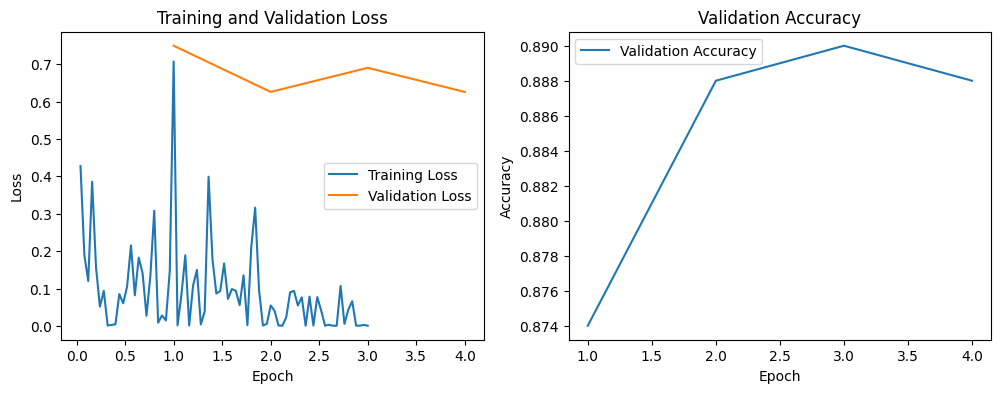

In [60]:
import matplotlib.pyplot as plt

# Extract metrics from trainer logs
train_logs = trainer.state.log_history
epochs = [log['epoch'] for log in train_logs if 'loss' in log]
train_loss = [log['loss'] for log in train_logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]
eval_acc = [log['eval_accuracy'] for log in train_logs if 'eval_accuracy' in log]

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
#plt.plot(range(1, 4), eval_loss, label='Validation Loss')
plt.plot(range(1, len(eval_loss) + 1), eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
#plt.plot(range(1, 4), eval_acc, label='Validation Accuracy')
plt.plot(range(1, len(eval_acc) + 1), eval_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

### Making Predictions on Test Data

In [53]:
test_dataset = tokenized_dataset['test'].shuffle(seed=42).select(range(5000))

In [54]:
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [55]:
# Make predictions using the trained model
predictions = trainer.predict(test_dataset)

In [56]:
# Extract predicted labels and probabilities
import numpy as np
from scipy.special import softmax

pred_logits = predictions.predictions  # Raw logits
pred_labels = np.argmax(pred_logits, axis=-1)  # Predicted class labels (0 or 1)
pred_probs = softmax(pred_logits, axis=-1)  # Predicted probabilities

# True labels from the test set
true_labels = predictions.label_ids

# Print some example predictions
for i in range(5):
    print(f"Review {i+1}:")
    print(f"True Label: {true_labels[i]}")
    print(f"Predicted Label: {pred_labels[i]}")
    print(f"Predicted Probabilities: {pred_probs[i]}")
    print()

Review 1:
True Label: 1
Predicted Label: 1
Predicted Probabilities: [4.268672e-04 9.995732e-01]

Review 2:
True Label: 1
Predicted Label: 1
Predicted Probabilities: [8.4311300e-04 9.9915683e-01]

Review 3:
True Label: 0
Predicted Label: 0
Predicted Probabilities: [9.9956995e-01 4.3005295e-04]

Review 4:
True Label: 1
Predicted Label: 1
Predicted Probabilities: [5.2450033e-04 9.9947554e-01]

Review 5:
True Label: 0
Predicted Label: 0
Predicted Probabilities: [9.9953163e-01 4.6833407e-04]



In [57]:
# Evaluate performance on the test set
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.8918
Test F1 Score: 0.8918


---

## 8. Save the Model
Save the fine-tuned model and tokenizer for future use or deployment.

In [61]:
trainer.save_model('./bert_sentiment_model')
tokenizer.save_pretrained('./bert_sentiment_model')

('./bert_sentiment_model/tokenizer_config.json',
 './bert_sentiment_model/special_tokens_map.json',
 './bert_sentiment_model/vocab.txt',
 './bert_sentiment_model/added_tokens.json')

---

## 10. Conclusion
The fine-tuned BERT model achieved a test accuracy of [89.18%] and an F1 score of [89.18%] on 5000 IMDb test samples, demonstrating strong performance in sentiment classification. Training on a subset of 2000 samples, the model peaked at Epoch 2 (validation loss 0.625802), with slight overfitting by Epoch 3. This highlights BERT’s ability to leverage pre-trained knowledge for NLP tasks with limited data. These results suggest potential for real-world applications like automated review analysis, with further gains possible by scaling to the full dataset.